In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn import decomposition
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)

## Get Data

In [ ]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car'
]

In [19]:
def create_vocabulary(corpus):
    vocabulary = {}
    i = 0
    for s in corpus:
        for w in s.split():
            if w not in vocabulary:
                vocabulary[w] = i
                i += 1
    return vocabulary

def prepare_set(corpus, n_gram=1):
    columns = ["Input"] + [f"Output{i+1}" for i in range(n_gram * 2)]
    result = pd.DataFrame(columns=columns)
    for sentence in corpus:
        for i, w in enumerate(sentence.split()):
            inp = [w]
            out = []
            for n in range(1, n_gram + 1):
                # backward
                if (i - n) >= 0:
                    out.append(sentence.split()[i - n])
                else:
                    out.append('<pad>')

                # forward
                if (i + n) < len(sentence.split()):
                    out.append(sentence.split()[i + n])
                else:
                    out.append('<pad>')
            row = pd.DataFrame([inp + out], columns=columns)
            result = result.append(row, ignore_index=True)
    return result

def prepare_set_pair(corpus, n_gram=1):
    columns = ["Input", "Output"]
    result = pd.DataFrame(columns=columns)
    for sentence in corpus:
        for i, w in enumerate(sentence.split()):
            inp = w
            for n in range(1, n_gram + 1):
                # backward
                if (i - n) >= 0:
                    out = sentence.split()[i-n]
                    row = pd.DataFrame([[inp, out]], columns=columns)
                    result = result.append(row, ignore_index=True)
                # forward
                if (i + n) < len(sentence.split()):
                    out = sentence.split()[i+n]
                    row = pd.DataFrame([[inp, out]], columns=columns)
                    result = result.append(row, ignore_index=True)
    return result

In [7]:
stop_words = stopwords.words('english')

def preprocess(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ".join(out))
    return result

corpus = preprocess(corpus)
corpus
    

['drink milk',
 'drink cold water',
 'drink cold cola',
 'drink juice',
 'drink cola',
 'eat bacon',
 'eat mango',
 'eat cherry',
 'eat apple',
 'juice sugar',
 'cola sugar',
 'mango fruit',
 'apple fruit',
 'cherry fruit',
 'berlin germany',
 'boston usa',
 'mercedes germany',
 'mercedes car',
 'ford usa',
 'ford car']

In [8]:
vocabulary = create_vocabulary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'bacon': 7,
 'mango': 8,
 'cherry': 9,
 'apple': 10,
 'sugar': 11,
 'fruit': 12,
 'berlin': 13,
 'germany': 14,
 'boston': 15,
 'usa': 16,
 'mercedes': 17,
 'car': 18,
 'ford': 19}

In [63]:
train_emb = prepare_set(corpus, n_gram=2)
train_emb.head()

,Input,Output1,Output2,Output3,Output4
0,drink,<pad>,milk,<pad>,<pad>
1,milk,drink,<pad>,<pad>,<pad>
2,drink,<pad>,cold,<pad>,water
3,cold,drink,water,<pad>,<pad>
4,water,cold,<pad>,drink,<pad>


In [64]:
train_emb = prepare_set_pair(corpus, n_gram=2)
train_emb.head()

,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink


In [65]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0


## Model

In [91]:
# device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

vocab_size = len(vocabulary)
def get_input_tensor(tensor):
    '''1D index -> 2D one-hot tensor'''
#     size = tensor.shape[0]
    size = [*tensor.shape][0]
    inp = torch.zeros(size, vocab_size, device=device).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

In [92]:
embedding_dims = 5
init_range = 0.5 / embedding_dims
W1 = Variable(torch.randn(vocab_size, embedding_dims, device=device).uniform_(-init_range, init_range).float(), requires_grad=True)
W2 = Variable(torch.randn(embedding_dims, vocab_size, device=device).uniform_(-init_range, init_range).float(), requires_grad=True)
print(W1.shape, W2.shape)

torch.Size([20, 5]) torch.Size([5, 20])


## Train

In [94]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []

for epo in range(num_epochs):
    for x, y in zip(DataLoader(torch.from_numpy(train_emb.Input.values).to(device), batch_size=train_emb.shape[0]), DataLoader(torch.from_numpy(train_emb.Output.values).to(device), batch_size=train_emb.shape[0])):
        input_tensor = get_input_tensor(x) # (N, V)
        h = input_tensor.mm(W1) # (1, H)
        y_pred = h.mm(W2) # (1, V)
        
        loss_f = torch.nn.CrossEntropyLoss()
        loss = loss_f(y_pred, y)
        loss.backward()
        
        with torch.no_grad():
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data

            W1.grad.data.zero_()
            W1.grad.data.zero_()
        if epo % 10 == 0:
            learning_rate *= lr_decay
        if epo % 100 == 0:
            print(f'Epoch {epo}, loss = {loss}')
        
        
        

Epoch 0, loss = 2.995100736618042
Epoch 100, loss = 1.1552451848983765
Epoch 200, loss = 0.9874715805053711
Epoch 300, loss = 1.3680248260498047
Epoch 400, loss = 1.0917840003967285
Epoch 500, loss = 1.090592861175537
Epoch 600, loss = 1.417537808418274
Epoch 700, loss = 1.0843068361282349
Epoch 800, loss = 1.0191487073898315
Epoch 900, loss = 1.035744071006775
Epoch 1000, loss = 1.0058356523513794
Epoch 1100, loss = 0.9605559706687927
Epoch 1200, loss = 0.9393689632415771
Epoch 1300, loss = 0.9179224371910095
Epoch 1400, loss = 0.9081981182098389
Epoch 1500, loss = 0.9042484760284424
Epoch 1600, loss = 0.903984010219574
Epoch 1700, loss = 0.9041524529457092
Epoch 1800, loss = 0.9038423895835876
Epoch 1900, loss = 0.9032694697380066


## Visualize

C:\tools\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


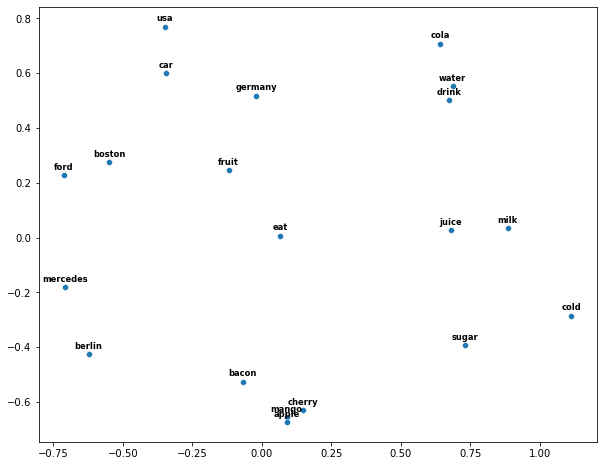

In [95]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()

svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:, 0]
y = W1_dec[:, 1]
plot = sns.scatterplot(x, y)

for i in range(0, W1_dec.shape[0]):
    plot.text(x[i], y[i] + 2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold')

C:\tools\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


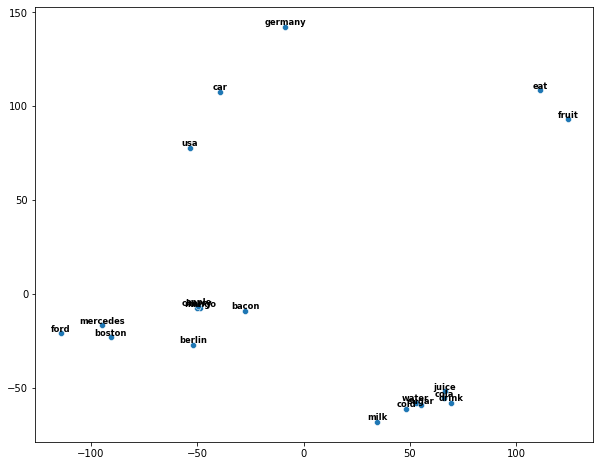

In [96]:
W2_dec = svd.fit_transform(W2)
x1 = W2_dec[:,0]
y1 = W2_dec[:,1]
plot1 = sns.scatterplot(x1, y1)
for i in range(0,W2_dec.shape[0]):
     plot1.text(x1[i], y1[i]+1, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');